In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
%matplotlib notebook

In [2]:
N = 5 # total population
Rsi = 1

I_0 = 1
S_0 = 4

Q = np.zeros((N + 1, N + 1))

for i in range(1, N): # number of infectives
    Q[i, i - 1] = Rsi * i * (N - i)
    Q[i, i] = - (Rsi * i * (N - i))

In [3]:
def doobGillespie(diagonal, currState):
    times = [0]
    state = currState
    # print(- np.diag(Q)[state])
    timeSpent = np.random.exponential(scale=1/diagonal[state])
    state -= 1
    times.append(timeSpent)
    # print(state)
    while state != 0 and (state != Q.shape[0] - 1):
        # print(- np.diag(Q)[state])
        timeSpent = np.random.exponential(scale=1/(diagonal[state]))
        state -= 1
        times.append((times[-1] + timeSpent))
        # print(state)
    return times

doobGillespie(- np.diag(Q), S_0)

[0,
 0.12162297944520256,
 0.44383700022965333,
 0.5424732500152,
 0.5722561656471143]

In [4]:
searchIn = np.arange(20)
searchFor = {(searchIn[i] + searchIn[i + 1])/2 : (i, i + 1) for i in range(len(searchIn) - 1)}
print(searchIn)
print(searchFor)

def binSearch(searchIn, goal):
    if goal >= searchIn[-1]:
        return (len(searchIn) - 1, None)
    elif goal <= searchIn[0]:
        return (None, 0)
    else:
        low = 0
        upper = len(searchIn) - 1
        middle = int((upper + low)/2)
        while low < upper: # replace this
            # print("searching between " + str(low) + " and " + str(upper))
            if middle < len(searchIn) - 1:
                if searchIn[middle] <= goal and searchIn[middle + 1] >= goal:
                    return (middle, middle + 1)
            elif middle > 0:
                if searchIn[middle - 1] >= goal and searchIn[middle] <= goal:
                    return (middle, middle - 1)
            
            if goal > searchIn[middle]:
                low = middle + 1
            else: # goal < middle
                upper = middle - 1
            middle = int((upper + low)/2)
        return (middle, middle + 1)

for val, between in searchFor.items():
    assert binSearch(searchIn, val) == between

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
{0.5: (0, 1), 1.5: (1, 2), 2.5: (2, 3), 3.5: (3, 4), 4.5: (4, 5), 5.5: (5, 6), 6.5: (6, 7), 7.5: (7, 8), 8.5: (8, 9), 9.5: (9, 10), 10.5: (10, 11), 11.5: (11, 12), 12.5: (12, 13), 13.5: (13, 14), 14.5: (14, 15), 15.5: (15, 16), 16.5: (16, 17), 17.5: (17, 18), 18.5: (18, 19)}


In [14]:
ts = np.linspace(0.001, 2, num=20)

t_values = np.asarray([[0 for i in range(S_0 + 1)] for t in ts])
trials = 1000000
timings = np.zeros((trials, S_0 + 1))

diagonal = - np.diag(Q)

for trial in range(trials):
    timings[trial, :] = doobGillespie(diagonal, S_0)


In [15]:
for i, t in enumerate(ts, 0):
    for row in range(timings.shape[0]):
        low, upper = binSearch(timings[row, :], t)
        # So at time t, the number of susceptible is between index low and upper
        # 0 -> 4
        # 1 -> 3
        # 2 -> 2
        # 3 -> 1
        # 4 -> 0
        # if upper != None
        if low == None:
            print(timings[row, :])
        else:
            t_values[i, 4 - low] += 1

In [16]:
probs = t_values / np.sum(t_values, axis=1)[:, np.newaxis]

In [17]:
# Calculating the formulaic versions
four = lambda t : np.exp(-4 * t)
six = lambda t : np.exp(-6 * t) 
form = lambda t : [four(t), 
                    2 * (four(t) - six(t)), 
                    6 * (four(t) - six(t) - (2 * t * six(t))),
                    36 * ((t * four(t)) - four(t) + six(t) + (t * six(t))),
                    1 + (27 * four(t)) - (36 * t * four(t)) - (28 * six(t)) - (24 * t * six(t))
                   ]

<IPython.core.display.Javascript object>


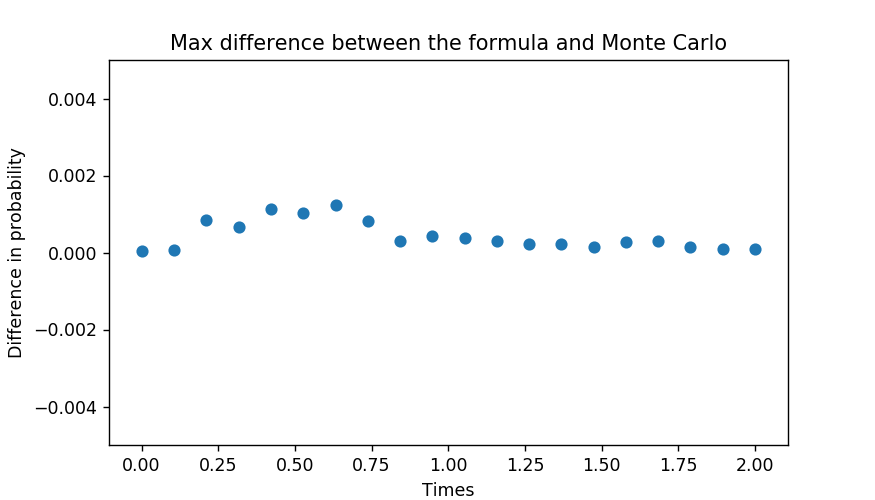

Text(0.5, 0, 'Times')

In [19]:
Ps = [expm(t * Q) for t in ts]

plt.figure(figsize=(7,4))

maxDiff = []

for index, (t, P) in enumerate(zip(ts, Ps), 0):
    monte = probs[index, :]
    calc = list(reversed(form(t)))
    maxDiff.append(max([abs(a - b) for a, b in zip(monte, calc)]))

plt.scatter(ts, maxDiff)
plt.ylim((-0.005, 0.005))
plt.title("Max difference between the formula and Monte Carlo")
plt.ylabel("Difference in probability")
plt.xlabel("Times")